In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Linear-3                  [-1, 128]       1,179,776
            Linear-4                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 4.58
Estimated Total Size (MB): 5.03
----------------------------------------------------------------
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301700
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.715646
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.578002
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.554773
Train Epoch: 0 [25600/6

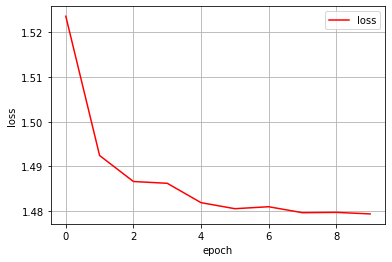

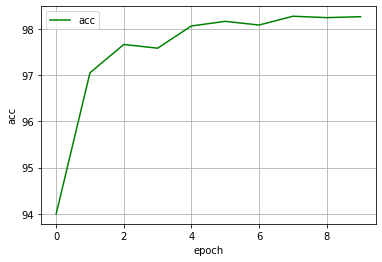

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


class Net(nn.Module):
    # ネットワークレイアウトは、スライドの絵を参照
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x)          
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

def train(model, device, train_loader, optimizer, epoch):
    model.train() # 学習するモードに設定
    for batch_idx, (data, target) in enumerate(train_loader): # train_loaderが渡すミニバッチごとに、入力と正解を取り出す
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 勾配クリア
        output = model(data) # 呼び出し可能オブジェクトの機能でforward呼び出し
        loss = F.cross_entropy(output, target) # ロス計算 
        loss.backward() # 逆伝播
        optimizer.step() # パラメータ更新
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval() # 学習しな評価モードに設定
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 勾配計算、パラメータ更新しない
        for data, target in test_loader: # テストローダーが提供するミニバッチ単位で、入力と正解を取り出す 
            data, target = data.to(device), target.to(device)
            output = model(data) # モデルで推論
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # バッチのロス計算
            pred = output.argmax(dim=1, keepdim=True)  # 出力1010このうち最大値をとるインデックスを取得
            correct += pred.eq(target.view_as(pred)).sum().item() # ミニバッチ内で正解数を加算
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    loss_list.append(test_loss)
    acc_list.append(acc)
    
loss_list = []
acc_list = []

def main():
    num_epochs = 10
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    # データセットクラス：データ。datasets.MNISTは、データセットクラスを継承した、MNISTデータを扱うクラス
    # データローダークラス：データセットからミニバッチ単位でロード
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       # データの前処理指定。テンソル形式変換、正規化のほか、クロップ、リサイズなどが準備されている
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)) # チャネルごとに、入力データを　(入力-平均)/標準偏差 へ標準化する
                       ])),
        batch_size=64, shuffle=True, **kwargs)
    # テンソル形式にして正規化してミニバッチ構成するローダー設定
    test_loader = torch.utils.data.DataLoader(                                          
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)

    model = Net().to(device)   # モデル設定
    summary(model, input_size=(1,28,28)) # モデルのパラメータ統計出力
    optimizer = optim.SGD(model.parameters(), lr=0.1) # 学習方法をSGDSGDに、学習レートを0.1
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7) # エポックごとに0.70.7倍ずつ学習を弱くする
    for epoch in range(num_epochs): # エポックを回す
        train(model, device, train_loader, optimizer, epoch) # トレーニング
        test(model, device, test_loader) # テスト
        scheduler.step() # 次のエポック

    plt.figure()
    plt.plot(range(num_epochs), loss_list, 'r-', label='loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

    plt.figure()
    plt.plot(range(num_epochs), acc_list, 'g-', label='acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.grid()

if __name__ == '__main__':
    main()

上記に、最後のデータのConvolution結果を表示するようにしたもの

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301288
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.869415
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.691254
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.601154
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.568890
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.557379
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.525217
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.557099
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.526729
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.484232

Test set: Average loss: 1.5322, Accuracy: 9307/10000 (93%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.513794
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.543926
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.504214
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.533089
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.510093
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.531663
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.521821
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.536165
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.479696
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 1, 28, 28])
torch.Size([1000, 32, 26, 26])
torch.Size([1000, 64, 24, 24])


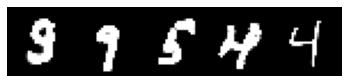

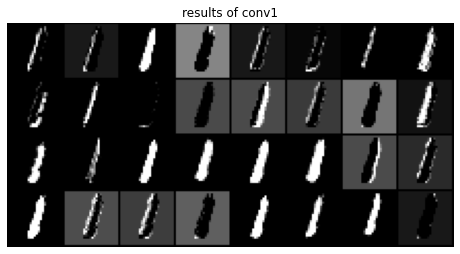

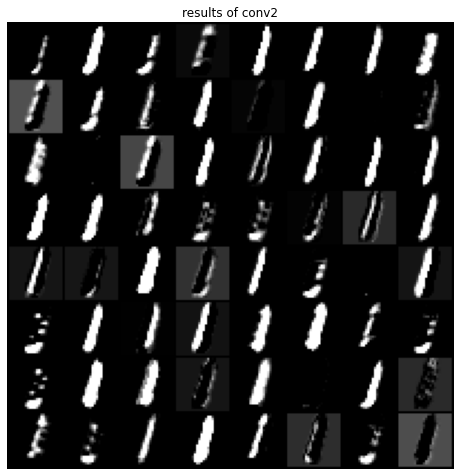

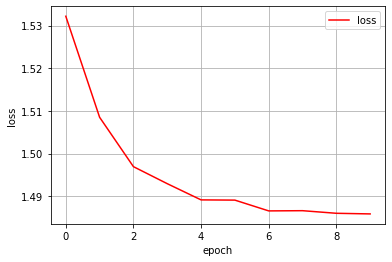

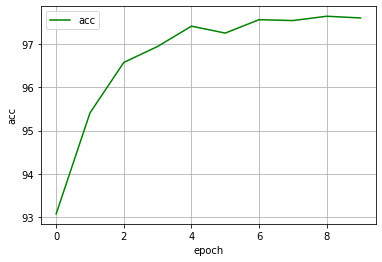

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
  npimg = img.numpy()
  # [c, h, w] => [h, w, c]
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) 
        self.save_conv1 = x  
        x = F.relu(x)          
        x = self.conv2(x)
        self.save_conv2 = x
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    loss_list.append(test_loss)
    acc_list.append(acc)
    
loss_list = []
acc_list = []

def main():
    num_epochs = 10
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)

    model = Net().to(device)
    # summary(model, input_size=(1,28,28))
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in range(num_epochs):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
    #torch.save(model.state_dict(), "mnist_cnn.pt")

    images, labels = iter(test_loader).next()
    print(images.size())
    images, labels = images[:5], labels[:5]
    imshow(torchvision.utils.make_grid(images, nrow=5, padding=1))
    plt.axis('off')
    
    # pick convolution results of last test input
    print(model.save_conv1.size())
    images = model.save_conv1[0].detach().cpu().view(32,1,26,26)
    plt.figure(figsize=(8,8))
    #plt.subplot(4,1,4)
    imshow(torchvision.utils.make_grid(images, nrow=8, padding=1))
    plt.title('results of conv1')
    plt.axis('off')
    print(model.save_conv2.size())
    images = model.save_conv2[0].detach().cpu().view(64,1,24,24)
    plt.figure(figsize=(8,16))
    #plt.subplot(4,1,2)
    imshow(torchvision.utils.make_grid(images, nrow=8, padding=1))
    plt.title('results of conv2')
    plt.axis('off')

    #print(model.state_dict()['conv2.weight'])

    plt.figure()
    plt.plot(range(num_epochs), loss_list, 'r-', label='loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

    plt.figure()
    plt.plot(range(num_epochs), acc_list, 'g-', label='acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.grid()

if __name__ == '__main__':
    main()

モデルをかえたもの。

最初に、テストの最初の入力画像を表示します。
エポックごとに、エポックの最初のテストデータに関し、1層目のConvolutionの結果画像と、２層目の結果画像を、表示します。

1本目は、2回のConvolutionの間にMaxPoolingを挟んでいます。2本目は、MaxPoolingの代わりに、2回目のConvolution時にDilation=2（カーネルサイズ5に相当）とやってグローバルなコンテキストを観察させています。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 1, 28, 28])


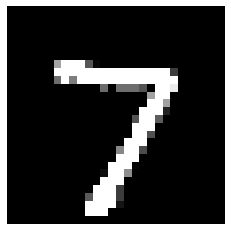

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 64, 14, 14]          18,496
       BatchNorm2d-4           [-1, 64, 14, 14]             128
            Linear-5                 [-1, 1024]      12,846,080
       BatchNorm1d-6                 [-1, 1024]           2,048
            Linear-7                  [-1, 128]         131,200
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 10]           1,290
Total params: 12,999,882
Trainable params: 12,999,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.59
Params size (MB): 49.59
Estimated Total Size (MB): 50.19
-----------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0384, Accuracy: 9888/10000 (98.88%)

torch.Size([1000, 32, 28, 28])


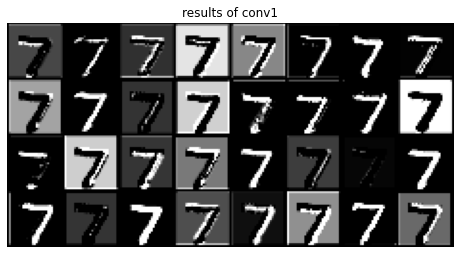

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 64, 14, 14])


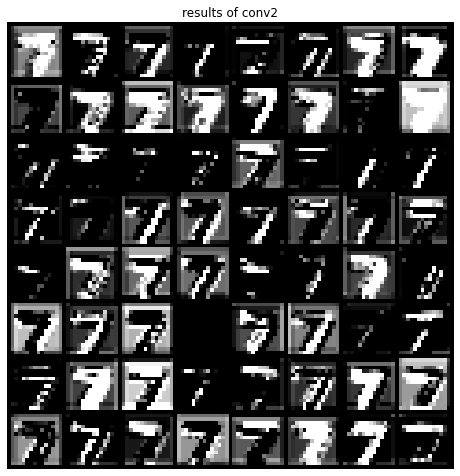

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.031876
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.018531
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.109131
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.011783
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.018170
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.011253
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.017114
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.016955
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.004606
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.020873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0308, Accuracy: 9907/10000 (99.07%)

torch.Size([1000, 32, 28, 28])


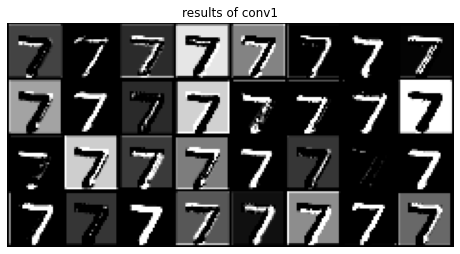

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 64, 14, 14])


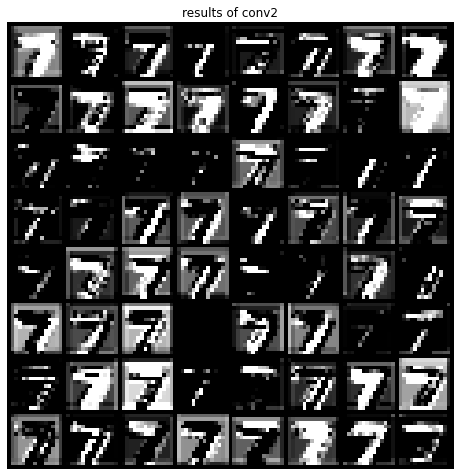

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.004221
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.031790
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003322
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.017466
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.028621
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.007102
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.004995
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.023063
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.009500
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.005428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0278, Accuracy: 9910/10000 (99.10%)

torch.Size([1000, 32, 28, 28])


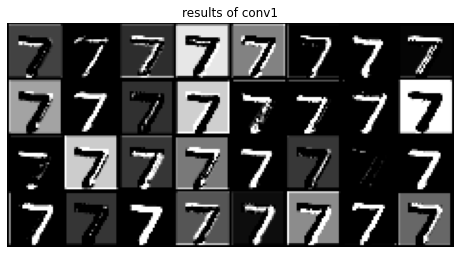

torch.Size([1000, 64, 14, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


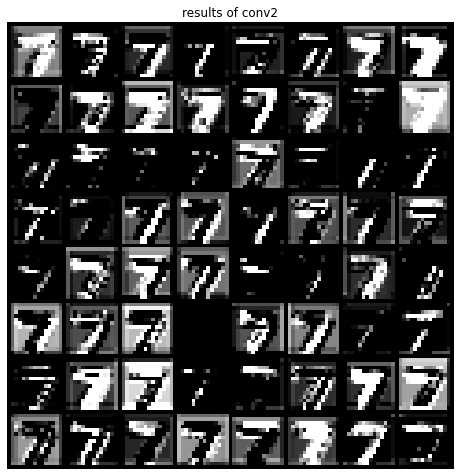

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.002155
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.003357
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.004153
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.003005
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.003672
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.013347
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.017019
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.007301
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.005665
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.004582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0263, Accuracy: 9908/10000 (99.08%)

torch.Size([1000, 32, 28, 28])


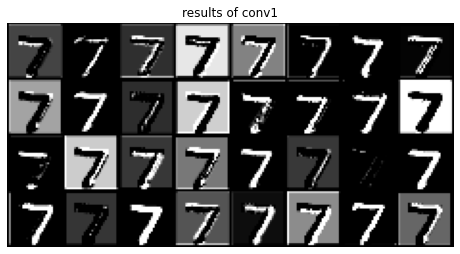

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 64, 14, 14])


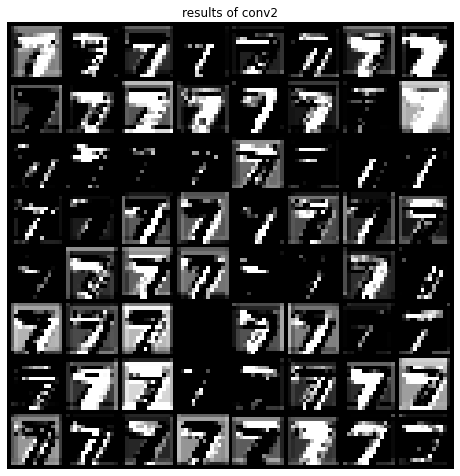

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.007065
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.001561
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.005277
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.004785
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.001878
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001808
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.005286
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001543
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.003696
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.006258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0260, Accuracy: 9908/10000 (99.08%)

torch.Size([1000, 32, 28, 28])


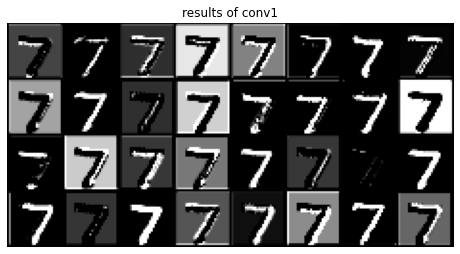

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 64, 14, 14])


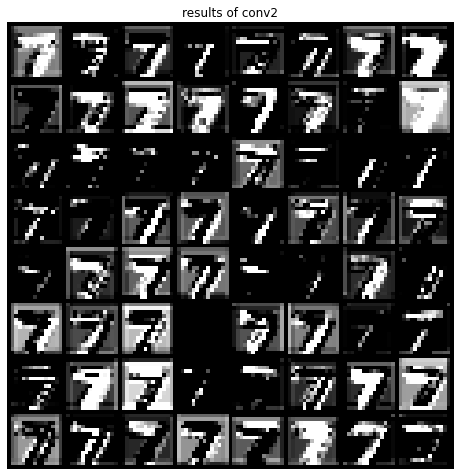

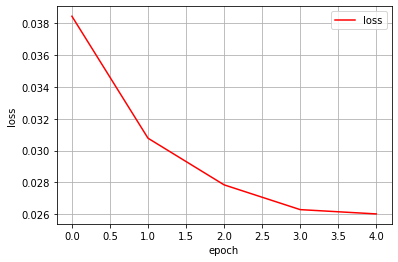

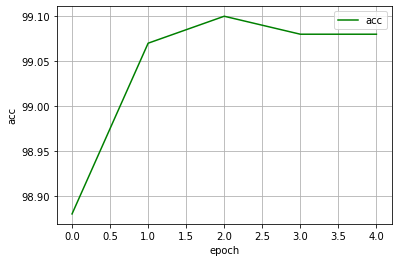

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
  npimg = img.numpy()
  # [c, h, w] => [h, w, c]
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1,padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(12544, 1024)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 128)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128,10)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.save_conv1 = None
        self.save_conv2 = None

    def forward(self, x):
        x = self.conv1(x) 
        if self.save_conv1 is None: self.save_conv1 = x  
        x = F.relu(self.bn1(x)) 
        x = F.max_pool2d(x, 2)         
        x = self.conv2(x)
        if self.save_conv2 is None: self.save_conv2 = x
        x = F.relu(self.bn2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.size())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))  

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    loss_list.append(test_loss)
    acc_list.append(acc)
    
loss_list = []
acc_list = []

def main():
    num_epochs = 5
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    torch.manual_seed(1)
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=False, **kwargs)

    images, labels = iter(test_loader).next()
    print(images.size())
    images, labels = images[:1], labels[:1]
    imshow(torchvision.utils.make_grid(images, nrow=5, padding=1))
    plt.axis('off')
    plt.show(block=False)

    model = Net().to(device)
    summary(model, input_size=(1,28,28))
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in range(num_epochs):
        train(model, device, train_loader, optimizer, epoch)

        model.save_conv1  = None
        model.save_conv2 = None
        test(model, device, test_loader)

        plt.figure(figsize=(8,8))
        # pick convolution results of last test input
        print(model.save_conv1.size())
        images = model.save_conv1[0].detach().cpu().view(32,1,28,28)
        imshow(torchvision.utils.make_grid(images, nrow=8, padding=1))
        plt.title('results of conv1')
        plt.axis('off')
        plt.show(block=False)

        plt.figure(figsize=(8,16))
        print(model.save_conv2.size())
        images = model.save_conv2[0].detach().cpu().view(64,1,14,14)
        imshow(torchvision.utils.make_grid(images, nrow=8, padding=1))
        plt.title('results of conv2')
        plt.axis('off')
        plt.show(block=False)

        scheduler.step()
    #torch.save(model.state_dict(), "mnist_cnn.pt")

    plt.figure()
    plt.plot(range(num_epochs), loss_list, 'r-', label='loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

    plt.figure()
    plt.plot(range(num_epochs), acc_list, 'g-', label='acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.grid()

if __name__ == '__main__':
    main()

モデルでdilationを使ったもの

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 1, 28, 28])


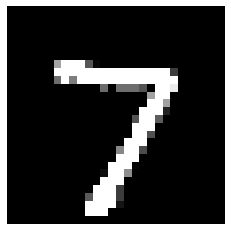

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         Dropout2d-5           [-1, 16, 28, 28]               0
            Linear-6                 [-1, 1024]      12,846,080
       BatchNorm1d-7                 [-1, 1024]           2,048
            Linear-8                  [-1, 128]         131,200
       BatchNorm1d-9                  [-1, 128]             256
        Dropout2d-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 12,983,418
Trainable params: 12,983,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0481, Accuracy: 9850/10000 (98.50%)



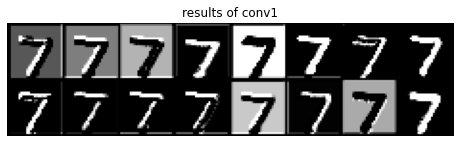

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


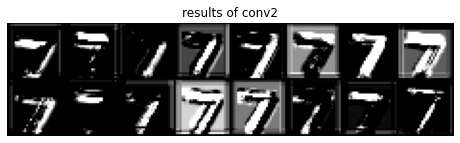

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.094581
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.092231
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.051970
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.039584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.037225
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.061896
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.040655
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.097087
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.074324
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.071963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0367, Accuracy: 9866/10000 (98.66%)



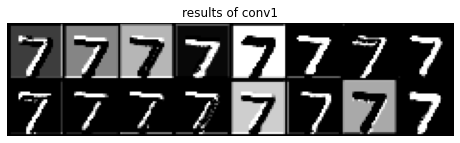

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


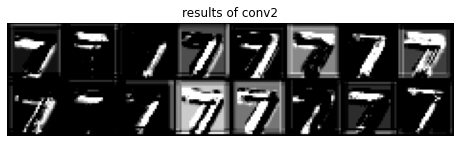

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.058983
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.065174
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.019311
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.017839
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.084463
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.082453
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.103805
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.229460
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.008195
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.040608


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0311, Accuracy: 9887/10000 (98.87%)



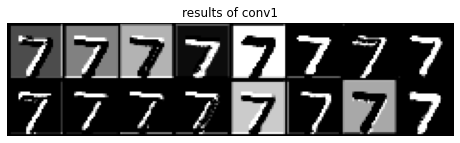

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


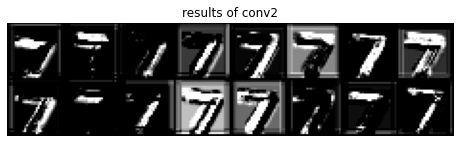

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.076587
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.009196
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.037803
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.030562
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.036561
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.026744
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.017774
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.067861
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.074609
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.022499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0271, Accuracy: 9910/10000 (99.10%)



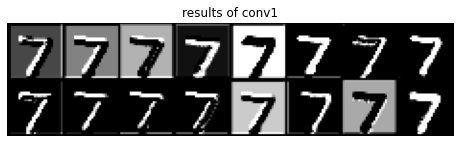

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


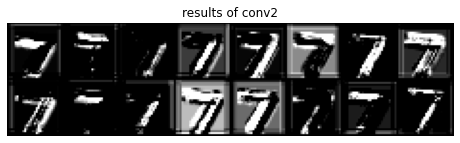

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.047972
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.065474
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.028234
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.071811
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.038142
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.042332
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.041945
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.048077
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.025092
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.040171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set: Average loss: 0.0263, Accuracy: 9911/10000 (99.11%)



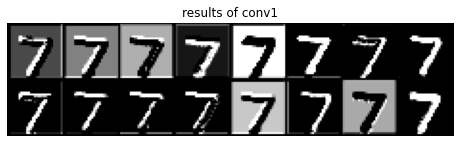

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


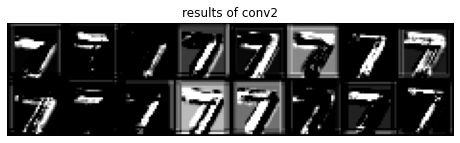

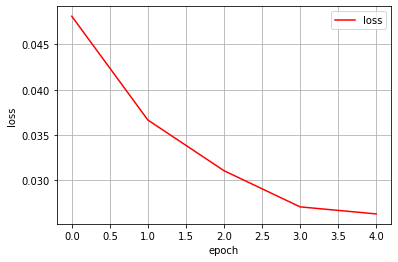

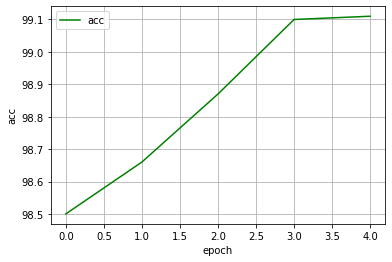

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


import torchvision
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline

def imshow(img):
  npimg = img.numpy()
  # [c, h, w] => [h, w, c]
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1,padding=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, padding=2, dilation=2)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(12544, 1024)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 128)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.save_conv1 = None
        self.save_conv2 = None

    def forward(self, x):
        x = self.conv1(x) 
        if self.save_conv1 is None: self.save_conv1 = x 
        x = F.relu(self.bn1(x))      
        x = self.conv2(x)
        if self.save_conv2 is None: self.save_conv2 = x   
        x = F.relu(self.bn2(x))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))  

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    loss_list.append(test_loss)
    acc_list.append(acc)
    
loss_list = []
acc_list = []

def main():
    num_epochs = 5
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    torch.manual_seed(1)
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=False, **kwargs)

    images, labels = iter(test_loader).next()
    print(images.size())
    images, labels = images[:1], labels[:1]
    imshow(torchvision.utils.make_grid(images, nrow=1, padding=1))
    plt.axis('off')
    plt.show(block=False)

    model = Net().to(device)
    summary(model, input_size=(1,28,28))
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in range(num_epochs):
        train(model, device, train_loader, optimizer, epoch)

        model.save_conv1 = None
        model.save_conv2 = None
        test(model, device, test_loader)

        #print('conv1.weight:')
        #print(model.state_dict()['conv1.weight'].size())
        #print(model.state_dict()['conv1.weight'])

        images = model.save_conv1[0].detach().cpu().view(16,1,28,28)
        plt.figure(figsize=(8,8))
        imshow(torchvision.utils.make_grid(images, nrow=8, padding=1))
        plt.title('results of conv1')
        plt.axis('off')
        plt.show(block=False)

        #print('conv2.weight:')
        #print(model.state_dict()['conv2.weight'].size())
        #print(model.state_dict()['conv2.weight'])

        images = model.save_conv2[0].detach().cpu().view(16,1,28,28)
        plt.figure(figsize=(8,8))
        imshow(torchvision.utils.make_grid(images, nrow=8, padding=1))
        plt.title('results of conv2')
        plt.axis('off')
        plt.show(block=False)

        #print('fc1.weight:')
        #print(model.state_dict()['fc1.weight'].size())
        #print(model.state_dict()['fc1.weight'])

        #print('fc2.weight:')
        #print(model.state_dict()['fc2.weight'].size())
        #print(model.state_dict()['fc2.weight'])

        #print('fc3.weight:')
        #print(model.state_dict()['fc3.weight'].size())
        #print(model.state_dict()['fc3.weight'])

        scheduler.step()
    #torch.save(model.state_dict(), "mnist_cnn.pt")
    
    plt.figure()
    plt.plot(range(num_epochs), loss_list, 'r-', label='loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

    plt.figure()
    plt.plot(range(num_epochs), acc_list, 'g-', label='acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.grid()

if __name__ == '__main__':
    main()